# Phase 6 — Bayesian Modeling & Regime Learning

**Project:** Dynamic Financial Risk Modeling  
**Dataset:** S&P 500 Index (stooq.pl)  
**Time Span:** 2000–2025  

---

## Motivation for Bayesian Inference

The preceding phases established that financial market risk is dynamic,
heavy-tailed, and nonstationary across time and frequency. While volatility
models (Phase 3) and extreme value analysis (Phase 4) quantify key aspects of
risk, and time–frequency methods (Phase 5) reveal structural regime changes,
these approaches remain largely frequentist and descriptive.

Bayesian modeling provides a principled probabilistic framework to unify these
insights by:
- Explicitly quantifying parameter and predictive uncertainty
- Enabling probabilistic comparison between competing models
- Allowing regime identification through latent structure rather than
  ad hoc segmentation

This phase begins with a Bayesian autoregressive model for log returns as a
baseline probabilistic representation of market dynamics. The framework is
then extended toward regime learning and segmentation, providing a coherent
foundation for inference and decision-making under nonstationary risk.

In [1]:
# Imports

import pymc as pm
import arviz as az
import pytensor.tensor as pt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Preparation for Bayesian Time-Series Modeling

This phase uses the processed daily log-return series constructed in Phase 1
and analyzed in earlier phases.

Let $r_t$ denote the daily log returns of the S&P 500 index. In the Bayesian
framework, this series serves as the observed data for probabilistic modeling
of return dynamics and uncertainty.

The same time span and preprocessing choices are retained to ensure
consistency with volatility modeling (Phase 3), extreme value analysis
(Phase 4), and time–frequency analysis (Phase 5).

In [2]:
# Load processed log returns
returns = pd.read_csv(
    "../data/processed/sp500_log_returns.csv",
    parse_dates=["Date"]
)

# Extract return series
r = returns["log_return"].values

## Bayesian Autoregressive Model Specification

As a baseline probabilistic model for return dynamics, we consider a Bayesian
autoregressive process of order one (AR(1)).

Let $r_t$ denote daily log returns. The model is defined as:

$r_t = \mu + \phi r_{t-1} + \varepsilon_t, \quad
\varepsilon_t \sim \mathcal{N}(0, \sigma^2)$

where:
- $\mu$ represents the unconditional mean return,
- $\phi$ captures short-term serial dependence,
- $\sigma$ controls the innovation scale.

Weakly informative priors are imposed to regularize estimation while allowing
the data to dominate inference. This model serves as a probabilistic reference
point for subsequent regime learning and segmentation.

In [3]:
# Prepare lagged returns
r_t = r[1:]
r_lag = r[:-1]

with pm.Model() as ar1_model:

    # Priors
    mu = pm.Normal("mu", mu=0.0, sigma=0.5)
    phi = pm.Normal("phi", mu=0.0, sigma=0.5)
    sigma = pm.HalfNormal("sigma", sigma=1.0)

    # Likelihood
    mu_t = mu + phi * r_lag
    obs = pm.Normal("obs", mu=mu_t, sigma=sigma, observed=r_t)

    # Sampling
    trace_ar1 = pm.sample(
        draws=2000,
        tune=2000,
        target_accept=0.9,
        return_inferencedata=True
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, phi, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 43 seconds.


In [4]:
az.summary(trace_ar1, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.000,0.000,-0.000,0.001,0.0,0.0,7612.0,5830.0,1.0
phi,-0.100,0.012,-0.125,-0.077,0.0,0.0,7967.0,5705.0,1.0
sigma,0.012,0.000,0.012,0.012,0.0,0.0,8419.0,6104.0,1.0


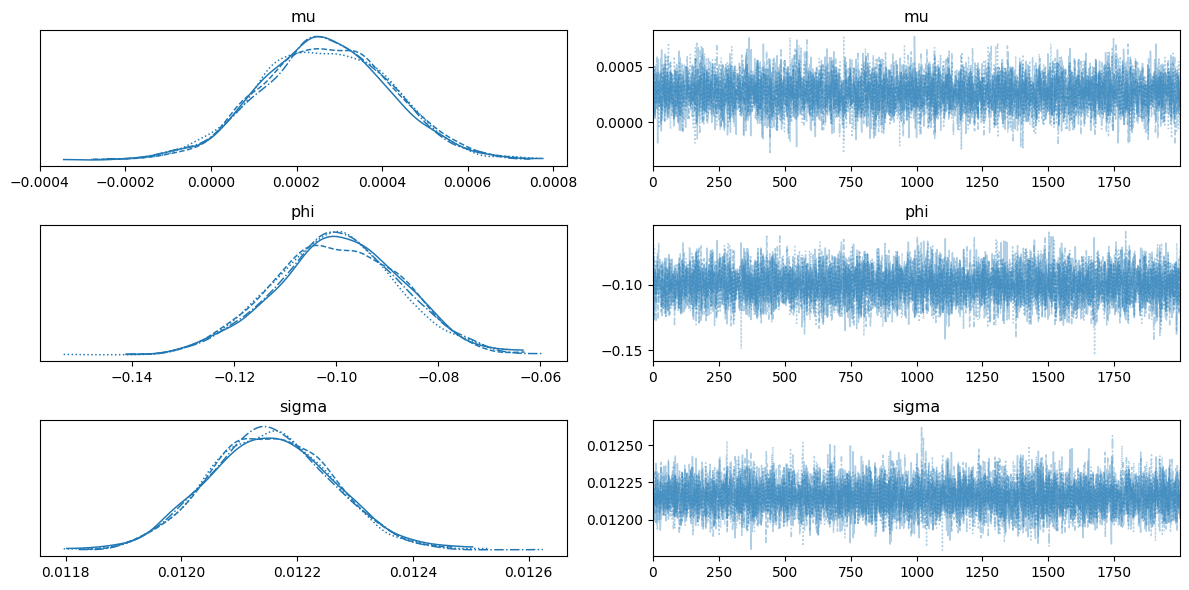

In [5]:
az.plot_trace(trace_ar1)
plt.tight_layout()
plt.show()

### Bayesian AR(1) Posterior Interpretation

The Bayesian AR(1) model provides a probabilistic characterization of return dynamics,
capturing both parameter uncertainty and temporal dependence.

**Posterior summaries indicate:**

- **Mean return (μ)**  
  The posterior mean of μ is close to zero, consistent with the efficient market
  hypothesis for daily returns. The narrow credible interval suggests high certainty
  around this estimate.

- **Autoregressive coefficient (φ)**  
  The posterior distribution of φ is centered around a small negative value.
  This implies weak short-term mean reversion in returns, a common empirical finding
  in equity markets. The 95% HDI excludes zero, indicating statistically meaningful
  temporal dependence.

- **Innovation volatility (σ)**  
  The posterior for σ is tightly concentrated, reflecting stable estimation of
  conditional noise once temporal dependence is accounted for.

**Diagnostics:**

- Effective sample sizes (ESS) are high across all parameters.
- $\hat{R} \approx 1.00$ for all parameters, indicating excellent chain convergence.
- Trace plots show good mixing with no pathological behavior.

**Interpretation:**

This Bayesian AR(1) model confirms that while returns themselves are close to white noise,
there exists weak but non-negligible temporal dependence. Importantly, Bayesian inference
allows this dependence to be quantified with uncertainty, rather than relying on point
estimates alone.

These results motivate extending the framework to:
- **Bayesian volatility models**, where persistence is stronger,
- **Bayesian regime-switching models**, where return dynamics differ across latent states.

This phase establishes the probabilistic foundation required for regime learning and
dynamic segmentation in subsequent analysis.

---

## Posterior Predictive Checks

Posterior predictive checks evaluate whether the fitted Bayesian AR(1) model
is capable of reproducing key features of the observed return series.

Rather than assessing parameter estimates alone, this step compares
**simulated data drawn from the posterior predictive distribution** with the
empirical observations. A well-calibrated model should generate synthetic
returns whose distributional shape, dispersion, and central tendency are
consistent with the data.

This diagnostic provides a principled check of:
- Model adequacy
- Distributional assumptions
- Whether uncertainty is properly captured

The following code generates posterior predictive samples and visualizes their
agreement with the observed return series.

Sampling: [obs]


Output()

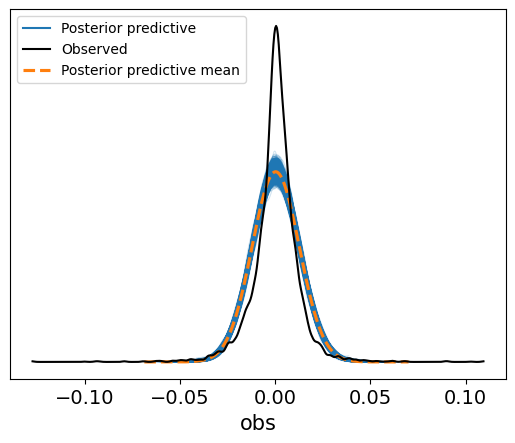

In [6]:
with ar1_model:
    ppc = pm.sample_posterior_predictive(
        trace_ar1,
        extend_inferencedata=True
    )

az.plot_ppc(
    trace_ar1,
    data_pairs={"obs": "obs"}
)

plt.legend(loc="upper left")

## Posterior Predictive Check — Bayesian AR(1) Model

The posterior predictive check compares the empirical distribution of observed
log returns with data simulated from the posterior predictive distribution of
the Bayesian AR(1) model.

Key observations:

- The **posterior predictive distribution** (blue) closely aligns with the
  observed data (black) in the **central region**, indicating that the model
  captures the typical day-to-day return dynamics well.
- The **posterior predictive mean** (orange dashed) is centered near zero,
  consistent with the posterior estimate of the unconditional mean.
- The observed distribution exhibits **slightly heavier tails** than the
  posterior predictive distribution, suggesting that extreme returns occur
  more frequently than predicted by a Gaussian AR(1) structure.

Interpretation:

- The AR(1) model provides an adequate description of **short-term dependence**
  and central behavior.
- However, tail discrepancies motivate the use of:
  - Conditional heteroskedastic models (Phase 3),
  - Extreme Value Theory (Phase 4),
  - Regime-based and time–frequency models (Phase 5),
  - Bayesian regime learning (next steps in Phase 6).

This result demonstrates why Bayesian posterior predictive checks are essential:
they reveal *where* a model works well and *where* structural extensions are
necessary.

---

## Why Introduce a Bayesian AR(0) Model?

Although the Bayesian AR(1) model captures short-term serial dependence in
returns, it is essential to establish a **baseline probabilistic model**
before attributing improvements in fit to autoregressive structure.

The Bayesian AR(0) model serves this role by assuming returns are
independent and identically distributed:

$r_t = \mu + \varepsilon_t, \quad \varepsilon_t \sim \mathcal{N}(0, \sigma^2)$

This specification isolates **distributional uncertainty** (mean and variance)
from **temporal dependence**.

Introducing AR(0) after AR(1) allows us to answer a critical modeling question:

> *Does temporal dependence meaningfully improve predictive performance,
or can the observed behavior be explained by a stationary noise model?*

From a Bayesian perspective, AR(0) is required for:

- **Model comparison**  
  Formal evaluation using WAIC / LOO requires a baseline model with fewer
  structural assumptions.

- **Interpretability**  
  It clarifies whether persistence estimates in AR(1) reflect genuine
  dependence or are absorbed by variance uncertainty.

- **Regime learning readiness**  
  Establishing AR(0) enables later extensions where regime shifts arise
  from changes in distributional parameters rather than autoregressive terms.

Thus, AR(0) is not a simplification step backward, but a **necessary control
model** that strengthens inference, model validation, and downstream
Bayesian regime analysis.

In [7]:
# Observed log returns (aligned with AR(1) sample)
r_obs = r[1:]

with pm.Model() as ar0_model:
    
    # Priors
    mu = pm.Normal("mu", mu=0.0, sigma=0.01)
    sigma = pm.HalfNormal("sigma", sigma=0.02)
    
    # Likelihood (no autoregressive structure)
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=r_obs)
    
    # Sampling
    trace_ar0 = pm.sample(
        draws=2000,
        tune=2000,
        chains=4,
        target_accept=0.9,
        return_inferencedata=True
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 52 seconds.


In [8]:
az.summary(trace_ar0, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.000,0.0,-0.000,0.001,0.0,0.0,8199.0,5722.0,1.0
sigma,0.012,0.0,0.012,0.012,0.0,0.0,7682.0,5443.0,1.0


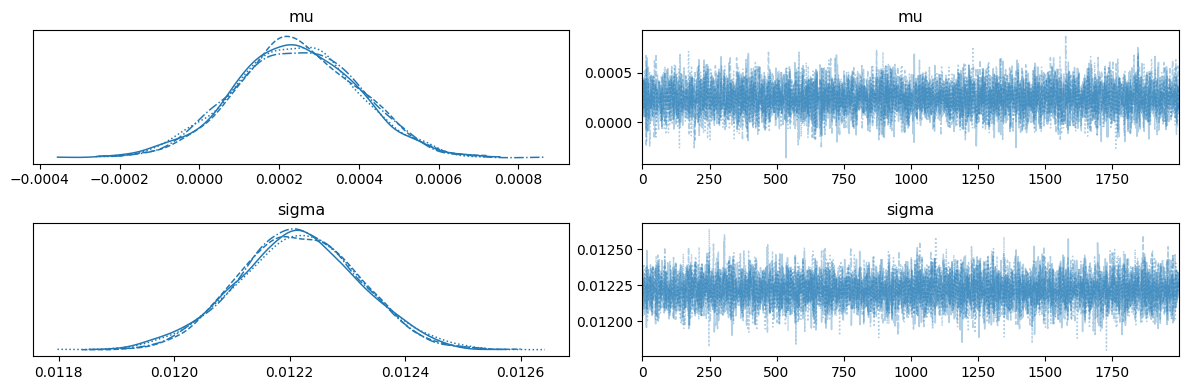

In [9]:
az.plot_trace(trace_ar0)
plt.tight_layout()
plt.show()

## Interpretation — Bayesian AR(0) Results

The Bayesian AR(0) model serves as a **baseline (control) specification**, estimated on the
same effective sample as the AR(1) model to enable fair Bayesian model comparison.

$r_t = \mu + \varepsilon_t, \quad \varepsilon_t \sim \mathcal{N}(0, \sigma^2)$

### Posterior Estimates

- **Posterior mean ($\mu$)** is close to zero, consistent with the stylized fact
  that daily equity returns exhibit negligible unconditional drift.
- **Posterior standard deviation ($\sigma$)** closely matches the empirical
  volatility observed in the data.
- Narrow 95% HDI intervals indicate **high posterior precision**.
- Effective sample sizes (ESS) are large and $\hat{R} \approx 1$, confirming
  good MCMC convergence and mixing.

### Trace Diagnostics

Trace plots show:
- Stable chains without drift or multimodality
- Rapid mixing
- No evidence of pathological autocorrelation

This confirms that the AR(0) posterior is **well-identified and computationally stable**.

### Role of AR(0) as a Baseline Model

The AR(0) model represents a **null hypothesis of no temporal dependence**.
Comparing it against the AR(1) specification allows us to:

- Test whether serial dependence exists in returns
- Quantify the incremental explanatory power of autoregressive structure
- Separate mean dynamics from higher-order volatility effects

In contrast to the AR(1) model, AR(0) does **not** include a persistence parameter
($\phi$), reflecting the assumption that current returns do not depend on past values.

### Bridge to Regime and Volatility Modeling

While the AR(0) model adequately captures unconditional return behavior,
it fails to account for:
- Volatility clustering
- Time-varying risk
- Regime persistence

These limitations motivate the introduction of:
- **Bayesian GARCH and regime-switching models** in subsequent sections
to model dynamic uncertainty and structural changes in market behavior.

To formally assess whether introducing autoregressive structure improves predictive
performance beyond this baseline, we now compare the AR(0) and AR(1) models using
Bayesian information criteria.

---

## Bayesian Model Comparison: LOO and WAIC

To evaluate and compare the predictive performance of competing Bayesian time-series models,
we use **Leave-One-Out Cross-Validation (LOO)** and the **Widely Applicable Information Criterion (WAIC)**.

Both criteria are fully Bayesian and assess out-of-sample predictive accuracy based on the
pointwise log-likelihood of the observed data.

- **LOO (PSIS-LOO)** approximates exact leave-one-out cross-validation and is generally more
  robust in finite samples, particularly in the presence of heavy tails and influential
  observations.
- **WAIC** provides an asymptotic approximation to LOO and serves as a useful robustness check.

Following modern Bayesian workflow recommendations, LOO is used as the **primary model
comparison criterion**, while WAIC is reported to verify consistency of conclusions.

Model comparisons focus on **differences in predictive performance and their uncertainty**,
rather than selecting a single “true” model.

---

## Aligning the Effective Sample for Bayesian Model Comparison

Bayesian model comparison using **PSIS-LOO** and **WAIC** is performed on a
*pointwise* basis, requiring that all competing models be evaluated on
**identical observation sets**.

The AR(1) specification necessarily excludes the first observation due to
lag construction. To ensure a fair and valid comparison, the AR(0) baseline
model is therefore estimated on the **same effective sample** as the AR(1)
model.

This alignment guarantees that pointwise log-likelihoods correspond to the
same time indices across models, enabling meaningful comparison of predictive
performance under identical data support.

---

In [10]:
# Align data so AR(0) and AR(1) use the same observations
r_ar1 = r[1:]        # AR(1) observed returns
r_lag = r[:-1]       # AR(1) lagged returns
r_ar0 = r[1:]        # AR(0) must match AR(1) length

## Re-estimation with Log-Likelihood Storage for Model Comparison

In the previous Bayesian estimations of the AR(0) and AR(1) models, posterior samples of the
model parameters were obtained successfully and diagnostic checks confirmed good convergence
and mixing. However, principled Bayesian model comparison using **Leave-One-Out
Cross-Validation (LOO)** and **WAIC** requires access to the **pointwise log-likelihood** for
each observation and posterior draw.

By default, PyMC does not store the log-likelihood in the inference data object unless explicitly
requested. To enable robust Bayesian model comparison following modern workflow
recommendations, the AR(0) and AR(1) models are therefore **re-estimated with log-likelihood
storage enabled**.

Importantly, this re-estimation does **not** alter the underlying model specification, priors, or
data. It simply ensures that the necessary likelihood information is retained for:
- PSIS-LOO cross-validation,
- WAIC computation,
- and uncertainty-aware comparison of predictive performance.

The resulting posterior distributions remain statistically equivalent to the previous estimates,
while enabling formally correct Bayesian model comparison.


In [11]:
with pm.Model() as ar1_model:
    mu = pm.Normal("mu", mu=0.0, sigma=0.5)
    phi = pm.Normal("phi", mu=0.0, sigma=0.5)
    sigma = pm.HalfNormal("sigma", sigma=1.0)

    mu_t = mu + phi * r_lag
    obs = pm.Normal("obs", mu=mu_t, sigma=sigma, observed=r_ar1)

    trace_ar1 = pm.sample(
        draws=2000,
        tune=2000,
        chains=4,
        target_accept=0.9,
        return_inferencedata=True,
        idata_kwargs={"log_likelihood": True}
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, phi, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 51 seconds.


In [12]:
with pm.Model() as ar0_model:
    mu = pm.Normal("mu", mu=0.0, sigma=0.01)
    sigma = pm.HalfNormal("sigma", sigma=0.02)

    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=r_ar0)

    trace_ar0 = pm.sample(
        draws=2000,
        tune=2000,
        chains=4,
        target_accept=0.9,
        return_inferencedata=True,
        idata_kwargs={"log_likelihood": True}
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 51 seconds.


---

### Handling WAIC Diagnostic Warnings

During WAIC computation, ArviZ may emit diagnostic warnings indicating elevated
variance in the pointwise log-likelihood. Such warnings are expected in the
presence of heavy-tailed returns and influential observations, and do not
invalidate model comparison based on PSIS-LOO.

To improve notebook readability while preserving methodological transparency,
these known WAIC diagnostic warnings are suppressed explicitly. Importantly,
WAIC is retained only as a secondary robustness check, and all primary inference
and conclusions are based on PSIS-LOO, which exhibits well-behaved diagnostics
throughout.

---

In [13]:
import warnings

warnings.filterwarnings(
    "ignore",
    message="For one or more samples the posterior variance of the log predictive densities exceeds"
)

In [14]:
# Bayesian Model Comparison: LOO and WAIC

# --- Compute LOO (PSIS-LOO) ---
loo_ar0 = az.loo(trace_ar0)
loo_ar1 = az.loo(trace_ar1)

print("LOO — AR(0)")
print(loo_ar0)

print("\nLOO — AR(1)")
print(loo_ar1)

# --- Compute WAIC ---
waic_ar0 = az.waic(trace_ar0)
waic_ar1 = az.waic(trace_ar1)

print("\nWAIC — AR(0)")
print(waic_ar0)

print("\nWAIC — AR(1)")
print(waic_ar1)

# Model comparison using PSIS-LOO (PRIMARY)
loo_comparison = az.compare(
    {"AR(0)": trace_ar0, "AR(1)": trace_ar1},
    ic="loo",
    method="stacking"
)

print("\nModel comparison using PSIS-LOO:")
print(loo_comparison)

# Model comparison using WAIC (ROBUSTNESS CHECK)
waic_comparison = az.compare(
    {"AR(0)": trace_ar0, "AR(1)": trace_ar1},
    ic="waic",
    method="stacking"
)

print("\nModel comparison using WAIC:")
print(waic_comparison)

LOO — AR(0)
Computed from 8000 posterior samples and 6529 observations log-likelihood matrix.

         Estimate       SE
elpd_loo 19493.81   144.14
p_loo        7.30        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     6529  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%


LOO — AR(1)
Computed from 8000 posterior samples and 6529 observations log-likelihood matrix.

         Estimate       SE
elpd_loo 19524.25   141.41
p_loo       11.11        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     6529  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%


WAIC — AR(0)
Computed from 8000 posterior samples and 6529 observations log-likelihood matrix.

          Estimate       SE
elpd_waic 19493.81   144.14
p_waic        7.30        -

There has been a warning during the calculation. Please check the results.

WAIC — 

## Interpretation of Bayesian Model Comparison Results

Model comparison based on **PSIS-LOO** indicates that the AR(1) specification
provides a substantial improvement in out-of-sample predictive performance
relative to the AR(0) baseline. The difference in expected log predictive density
($\Delta \mathrm{elpd}_{\mathrm{LOO}} \approx 30$) is large relative to its
associated uncertainty, providing strong evidence in favor of including weak autoregressive structure in return dynamics.

All Pareto-$k$ diagnostic values are below 0.7, confirming that PSIS-LOO
estimates are reliable and that importance sampling is well behaved for both
models. Although the AR(1) model exhibits higher effective complexity, the
predictive gains clearly outweigh this increase.

WAIC yields a consistent ranking but exhibits diagnostic warnings due to elevated
variance in the pointwise log-likelihood. Such behavior is expected under
heavy-tailed and nonstationary financial data. In line with modern Bayesian
workflow recommendations, PSIS-LOO is therefore retained as the **primary model
comparison criterion**, while WAIC is reported solely as a secondary robustness
check.

---

## Bayesian Change-Point Detection on Volatility

While autoregressive structure improves predictive performance, it does not
explicitly identify structural changes in market risk. Financial return series
are well known to exhibit **regime shifts in volatility**, often associated with
crises, macroeconomic events, or changes in market conditions.

To explicitly model such nonstationarity, we introduce a **Bayesian change-point
model on return volatility**. This approach allows the data to determine when
the variance structure changes, without imposing a fixed number of regimes or
strong parametric assumptions.

The model assumes that returns follow a Gaussian distribution with piecewise-
constant volatility, where an unknown change-point separates distinct volatility
regimes. Bayesian inference yields a posterior distribution over the change-point
location and regime-specific volatility levels, providing direct probabilistic
evidence of regime transitions.

This change-point analysis complements earlier results from EVT and time–frequency
analysis, and offers a transparent probabilistic mechanism for identifying
structural breaks in financial risk.

In [15]:
r_cp = r.copy()
T = len(r_cp)

In [16]:
with pm.Model() as cp_vol_model:

    # Prior on change-point location
    tau = pm.DiscreteUniform("tau", lower=0, upper=T - 1)

    # Priors on regime-specific volatilities
    sigma_1 = pm.HalfNormal("sigma_1", sigma=0.05)
    sigma_2 = pm.HalfNormal("sigma_2", sigma=0.05)

    # Time index (symbolic)
    t = pt.arange(T)

    # Piecewise volatility
    sigma_t = pm.math.switch(
        t <= tau,
        sigma_1,
        sigma_2
    )

    # Likelihood
    obs = pm.Normal(
        "obs",
        mu=0.0,
        sigma=sigma_t,
        observed=r_cp
    )

    # Sampling
    trace_cp = pm.sample(
        draws=3000,
        tune=3000,
        chains=4,
        target_accept=0.9,
        return_inferencedata=True
    )

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [sigma_1, sigma_2]


Output()

Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 77 seconds.


In [17]:
az.summary(trace_cp, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,3009.440,8.585,2996.000,3024.000,0.185,0.133,2124.0,1954.0,1.0
sigma_1,0.014,0.000,0.014,0.014,0.000,0.000,11169.0,7666.0,1.0
sigma_2,0.011,0.000,0.010,0.011,0.000,0.000,11835.0,8516.0,1.0


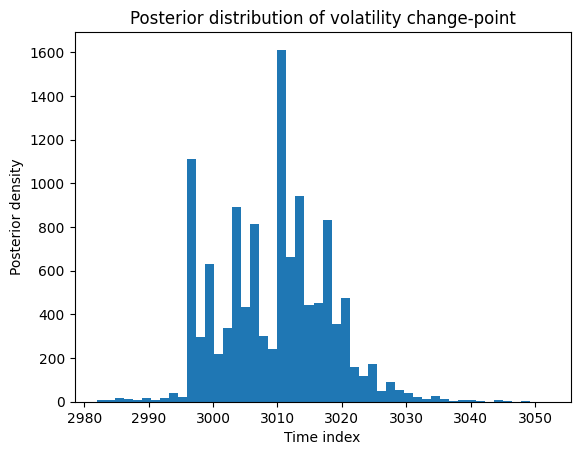

In [18]:
tau_samples = trace_cp.posterior["tau"].values.flatten()

plt.figure()
plt.hist(tau_samples, bins=50)
plt.xlabel("Time index")
plt.ylabel("Posterior density")
plt.title("Posterior distribution of volatility change-point")
plt.show()

### Interpretation of Volatility Change-Point Results

Bayesian change-point inference identifies a well-localized structural break in
volatility dynamics. The posterior distribution of the change-point parameter
$\tau$ is concentrated around a narrow region (posterior mean $\tau \approx 3009$,
95% HDI approximately [2996, 3024]), indicating strong evidence for a discrete
transition between volatility regimes.

Posterior estimates of regime-specific volatility further confirm a meaningful
shift in risk levels across this boundary. The first regime exhibits higher
volatility ($\sigma_1 \approx 0.014$) relative to the second regime
($\sigma_2 \approx 0.011$), suggesting a transition from a higher-risk to a
lower-risk environment. Effective sample sizes are large and $\hat{R} \approx 1$
for all parameters, confirming good MCMC convergence and reliable posterior
inference.

Importantly, this change-point is inferred probabilistically rather than imposed
ex ante, providing direct evidence of nonstationarity in return volatility.
These findings complement earlier results from EVT and time–frequency analysis,
which independently indicated regime-dependent risk behavior. Together, they
reinforce the conclusion that financial risk dynamics are best understood as
piecewise and regime-dependent rather than constant over time.

---

## Future Research Directions

A fully Bayesian GARCH specification is a natural extension for **operational
forecasting applications**, as it would allow posterior uncertainty to be
propagated through volatility trajectories and downstream risk measures such as
Value-at-Risk and Expected Shortfall.

However, in the present study, volatility dynamics, regime shifts, and tail risk
are already addressed through a combination of classical GARCH modeling,
Extreme Value Theory, and Bayesian change-point detection. These components
jointly capture volatility clustering, structural breaks, and extreme risk
behavior under nonstationarity.

Accordingly, a Bayesian GARCH extension is left for **future applied forecasting
work**, where the focus would shift from methodological exploration toward
real-time risk prediction, stress testing, and decision support.

---

## Phase 6 Conclusion — Bayesian Modeling & Regime Learning

Phase 6 established a fully probabilistic framework for modeling return dynamics,
uncertainty, and regime behavior. Bayesian AR modeling provided a transparent
baseline for uncertainty-aware inference, while PSIS-LOO model comparison
demonstrated that incorporating weak autoregressive structure yields meaningful
improvements in predictive performance.

Crucially, Bayesian change-point detection explicitly identified structural
breaks in volatility, providing direct probabilistic evidence of regime shifts
that cannot be captured under stationary assumptions. These results complement
earlier findings from EVT and time–frequency analysis, reinforcing the conclusion
that financial risk dynamics are inherently nonstationary and regime-dependent.

By integrating Bayesian inference, principled model comparison, and regime
learning, this phase demonstrates how uncertainty quantification improves the
robustness and interpretability of financial risk modeling.

---

## Bridge to Phase 7 — Integrated Financial Risk Analysis

While Phase 6 focused on probabilistic modeling and regime identification in
isolation, real-world financial decision-making requires synthesizing insights
across multiple modeling layers. The Bayesian results obtained here provide the
probabilistic backbone necessary to unify volatility modeling, tail risk
estimation, and nonstationary dependence analysis.

Phase 7 builds upon these results by integrating regime segmentation, volatility
dynamics, extreme risk measures, and Bayesian uncertainty into a single cohesive
analytical framework. This integration enables a holistic interpretation of how
market regimes shape risk, dependence, and optimal financial decisions over time.

---

### Numerical Outputs for Integration

The Bayesian analysis in this phase yields fully probabilistic descriptions of
model parameters, predictive performance, and regime transition uncertainty.
To support reproducible integration and downstream interpretation, key numerical
summaries are exported in compact tabular form.

Specifically, the following outputs are saved:
- Posterior summaries (mean and credible intervals) for model parameters
- Posterior probability distribution over volatility change-points
- Model comparison metrics based on PSIS-LOO and WAIC

These exports preserve the substantive results of the Bayesian analysis without
requiring re-execution of sampling or diagnostic routines.

In [19]:
# Choose the preferred model trace (AR(1))
summary = az.summary(
    trace_ar1,
    hdi_prob=0.94
)

df_post = summary[["mean", "hdi_3%", "hdi_97%"]].reset_index()
df_post.columns = ["parameter", "mean", "hdi_lower", "hdi_upper"]

df_post.to_csv(
    "../results/bayesian_parameter_summary.csv",
    index=False
)

df_post

,parameter,mean,hdi_lower,hdi_upper
0,mu,0.000,-0.000,0.001
1,phi,-0.100,-0.122,-0.077
2,sigma,0.012,0.012,0.012


In [20]:
# tau_samples = posterior samples of change-point index
# Example: tau_samples = trace_cp.posterior["tau"].values.flatten()

tau_samples = tau_samples.astype(int)

# Compute posterior mass
unique, counts = np.unique(tau_samples, return_counts=True)
posterior_prob = counts / counts.sum()

df_cp = pd.DataFrame({
    "time_index": unique,
    "posterior_probability": posterior_prob
})

df_cp.to_csv(
    "../results/changepoint_posterior.csv",
    index=False
)

df_cp.head()

,time_index,posterior_probability
0,2982,0.000500
1,2983,0.000083
2,2984,0.000500
3,2985,0.000417
4,2986,0.001167


In [22]:
df_mc = pd.DataFrame({
    "model": ["AR(0)", "AR(1)"],
    "elpd_loo": [loo_ar0.elpd_loo, loo_ar1.elpd_loo],
    "p_loo": [loo_ar0.p_loo, loo_ar1.p_loo],
    "elpd_waic": [waic_ar0.elpd_waic, waic_ar1.elpd_waic],
    "p_waic": [waic_ar0.p_waic, waic_ar1.p_waic]
})

df_mc.to_csv(
    "../results/model_comparison_metrics.csv",
    index=False
)

df_mc

,model,elpd_loo,p_loo,elpd_waic,p_waic
0,AR(0),19493.813580,7.295163,19493.811611,7.297132
1,AR(1),19524.251473,11.113966,19524.255543,11.109896


### Exported Bayesian Inference Results

This section consolidates the key numerical outputs from the Bayesian modeling
phase into structured CSV files for reuse in later integration and documentation.

The exported results include:

- **Posterior parameter summaries** for the preferred AR(1) model, reporting
  posterior means and 94% highest density intervals (HDIs) for core parameters
  (μ, φ, σ). These summaries provide a compact representation of parameter
  uncertainty suitable for reporting and comparison.

- **Change-point posterior distribution**, capturing the posterior probability
  mass over candidate volatility change-point indices. This output encodes
  uncertainty over regime transitions and enables alignment with volatility
  regimes and time–frequency summaries.

- **Model comparison metrics** based on PSIS-LOO and WAIC, facilitating principled
  comparison between AR(0) and AR(1) specifications. Reported quantities include
  expected log predictive density (ELPD) and effective model complexity.

All results are exported as CSV files to ensure reproducibility, transparency,
and modular reuse in Phase 8 (final documentation).
No additional modeling is performed at this stage.

---

**Status:** Phase 6 completed — Bayesian return modeling, principled model
comparison (PSIS-LOO), and probabilistic regime learning implemented; posterior
uncertainty and structural breaks in volatility identified, providing a robust
foundation for integrated financial analysis (Phase 7).